# Tech Challenge Fase 2

# Aluno
Klauber Lage - RM358972

Link vídeo no Youtube: https://www.youtube.com/watch?v=m9NDA8SMadw&ab_channel=KlauberLage

Link repositório no GitHub: https://github.com/klauberfreitas/fiap/tree/main/Fase%201/Tech%20Challenge

# O PROBLEMA
O desafio consiste em projetar, implementar e testar um sistema que 
utilize Algoritmos Genéticos para otimizar uma função ou resolver um problema 
complexo de otimização. Você pode escolher problemas como otimização de 
rotas, alocação de recursos e design de redes neurais.

# Tarefas
REQUISITOS DO PROJETO

- Definição do Problema: escolha um problema real que possa ser 
resolvido por meio de otimização genética. Descreva o problema, os 
objetivos e os critérios de sucesso.

- Testes e Resultados: realize testes para demonstrar a eficácia do 
algoritmo. Compare os resultados obtidos com métodos de solução 
convencionais.

- Documentação: forneça uma documentação completa do projeto, 
incluindo descrição do problema, detalhes da implementação do 
algoritmo, análises de resultados e conclusões.


### Referência:
[Documento PDF do Desafio](POSTECH-TechChallenge-IADT-Fase1.pdf)

---



# Relatório 

Usarei a mesma estrutura do primeiro Tech Challenge, seguindo a ordem de resolução dos problemas de acordo com o pedido.

Escolhi a otimização de rotas por ser o que mais me interessou, já que talvez eu consiga aplicar isto de certa forma, em um cenário real no trabalho.

### O problema
Criar um algortimo de Caixeiro Viajante (PCV).

### Objetivos
Encontrar a rota mais curta a ser percorrida em um conjunto de cidades, nisto, é necessário que cada uma delas seja visitada uma única vez e retorne ao ponto de partida.

### Critérios de sucesso
Usarei o mesmo fluxo descrito na aula Princípios e conceitos fundamentais dos Algoritmos Genéticos como critérios de sucesso.

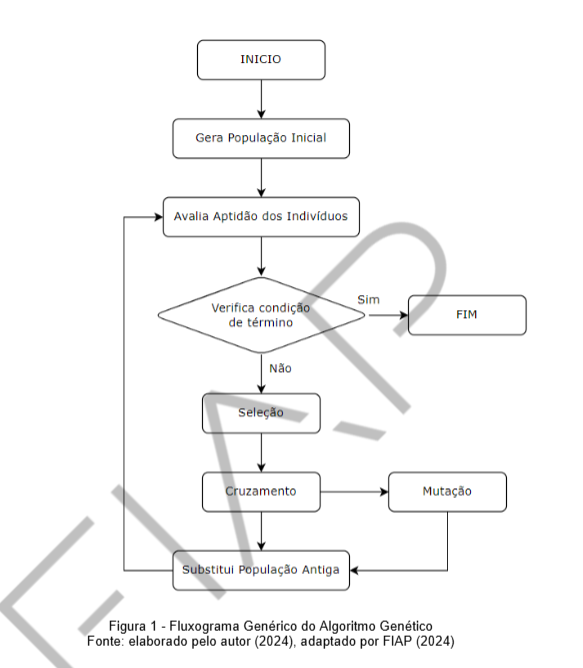

Também serão adicionadas as seguintes funcionalidades à lista:

- Armazenar o melhor indivíduo de geração para ser usado nas próximas gerações.
- O melhor indivíduo deve ser usado no próximo ciclo de execução.
- Adicionar mutação


# 0 - Instalação e importação de dependências

In [1]:
# ! pip install numpy random
# ! pip install pygame
# ! pip install python_tsp 

In [2]:
import pygame
import random
import numpy as np
import matplotlib.pyplot as plt
import itertools
import json
import copy

from typing import List, Tuple
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

pygame 2.6.1 (SDL 2.28.4, Python 3.11.1)
Hello from the pygame community. https://www.pygame.org/contribute.html


# Variáveis Globais
## Variáveis de estilo visual

In [3]:
# Define a cor branca
WHITE = (255, 255, 255)

# Define a cor preta
BLACK = (0, 0, 0)

# Define a cor vermelha
RED = (255, 0, 0)

# Define a cor cinza
GRAY = (128, 128, 128)

# Define a largura e altura da tela
WIDTH, HEIGHT = 1200, 600

# Define o tamanho do círculo que representa as cidades
CIRCLE_SIZE = 20


## Variáveis de configurações

In [4]:
# Define o tamanho da população no Algoritmo Genético
POPULATION_SIZE = 1000

# Define o número máximo de gerações
GENERATIONS = 400

# Define a probabilidade de mutação no Algoritmo Genético
MUTATION_PROBABILITY = 0.5

MUTATION_INTENSITY = 3

MUTATION_INTENSITY = 3

# Funções para gerar os gráficos

In [5]:
#Funções para gerar os gráficos
def draw_plot(screen, x_data, y_data, x_offset, y_offset, width, height, y_label="Fitness - Distance (pxls)"):
    fig, ax = plt.subplots(figsize=(width / 100, height / 100))
    ax.plot(x_data, y_data)
    ax.set_xlabel('Geração')
    ax.set_ylabel(y_label)
    canvas = FigureCanvas(fig)
    canvas.draw()
    raw_data = canvas.tostring_rgb()
    size = canvas.get_width_height()
    surf = pygame.image.fromstring(raw_data, size, "RGB")
    screen.blit(surf, (x_offset, y_offset))  
    plt.close(fig) 
        
        # Função para desenhar texto na tela
def draw_text(surface, text, position, font_size=20, color=BLACK):
    font = pygame.font.SysFont(None, font_size)
    text_surface = font.render(text, True, color)
    surface.blit(text_surface, position)

# Função para desenhar as cidades na tela com numeração
def draw_cities(surface, locations, color, size):
    for index, (x, y) in enumerate(locations):
        pygame.draw.circle(surface, color, (x, y), size)
        draw_text(surface, str(index), (x - size // 2, y - size // 2), font_size=28, color=BLACK)

def draw_paths(screen, route, color, width=1):
    for i in range(len(route)):
        pygame.draw.line(screen, color, route[i], route[(i + 1) % len(route)], width)

# Funções principais
Funções que controlam a população

In [6]:
# Gera poplução inicial
def generate_population(cities, size):
    return [random.sample(cities, len(cities)) for _ in range(size)]

def sort_population(population, fitness):
    return zip(*sorted(zip(population, fitness), key=lambda x: x[1]))

## Funções para controlar os melhores indivíduos

In [7]:
#Funções para controlar os melhores indivíduos
def calculate_fitness(route):
    total_distance = 0
    for i in range(len(route)):
        total_distance += np.sqrt((route[i][0] - route[(i + 1) % len(route)][0])**2 + (route[(i + 1) % len(route)][1] - route[i][1])**2)
    return total_distance

# Função para salvar o melhor indivíduo da geração
def save_best_individual(best_individual, best_fitness, filename="best_individual.json"):
    print("Indivíduo melhor foi encontrado e armazenado.")
    data = {
        "best_individual": best_individual,
        "best_fitness": round(best_fitness)
    }
    with open(filename, 'w') as f:
        json.dump(data, f)
        
# Função para carregar o melhor indivíduo salvo no arquivo json
def load_best_individual(filename="best_individual.json"):
    print("Carregado o melhor indivíduo da execução anterior.")
    try:
        with open(filename, 'r') as f:
            data = json.load(f)
            return data["best_individual"], data["best_fitness"]
    except FileNotFoundError:
        return None, None

In [8]:
# Alterado o mutate conforme orientado na aula Operadores Genéticos: Seleção, Cruzamento e Mutação, e mencionado no TODO. 
def mutate(solution: List[Tuple[float, float]], mutation_probability: float, mutation_intensity: int) -> List[Tuple[float, float]]:
    mutated_solution = copy.deepcopy(solution)

    # Check if mutation should occur    
    if random.random() < mutation_probability:
        
        # Ensure there are enough elements to perform an inversion
        if len(solution) < 2:
            return solution
        
        # Ensure mutation_intensity is within valid range
        mutation_intensity = min(mutation_intensity, len(solution) - 1)
        
        # Select a random start index for the inversion
        start_index = random.randint(0, len(solution) - mutation_intensity)
        
        # Invert the segment of the solution
        end_index = start_index + mutation_intensity
        mutated_solution[start_index:end_index] = list(reversed(mutated_solution[start_index:end_index]))
        
    return mutated_solution



In [9]:
# Scale cities locations to fit within the screen
def scale_cities(cities, width, height, padding=50):
    min_x = min(city[0] for city in cities)
    max_x = max(city[0] for city in cities)
    min_y = min(city[1] for city in cities)
    max_y = max(city[1] for city in cities)

    scale_x = (width - 2 * padding) / (max_x - min_x)
    scale_y = (height - 2 * padding) / (max_y - min_y)

    scaled_cities = [
        (
            int((city[0] - min_x) * scale_x) + padding,
            int((city[1] - min_y) * scale_y) + padding
        )
        for city in cities
    ]
    return scaled_cities

In [10]:

# Código baseado no order_crossover da aula Operadores Genéticos: Seleção, Cruzamento e Mutação
# def crossover(parent1, parent2):
#     """Realiza o crossover entre dois pais para gerar um filho."""
#     length = len(parent1)
#     start, end = sorted(random.sample(range(len(parent1)), 2))
#     # start_index = random.randint(0, length - 1)
#     # end_index = random.randint(start_index + 1, length)
#     child = [None] * len(parent1)
#     child[start:end] = parent1[start:end]
    
#     for city in parent2:
#         if city not in child:
#             for i in range(len(child)):
#                 if child[i] is None:
#                     child[i] = city
#                     break
#     return child


def order_crossover(parent1: List[Tuple[float, float]], parent2: List[Tuple[float, float]]) -> Tuple[List[Tuple[float, float]], List[Tuple[float, float]]]:
    length = len(parent1)

    # Escolher dois índices aleatórios para o crossover
    start_index = random.randint(0, length - 1)
    end_index = random.randint(start_index + 1, length)

    # Inicializar os filhos com cópias dos substrings dos pais
    child1 = parent1[start_index:end_index]
    child2 = parent2[start_index:end_index]

    # Preencher as posições restantes com genes dos outros pais
    remaining_positions1 = [i for i in range(length) if i < start_index or i >= end_index]
    remaining_positions2 = [i for i in range(length) if i < start_index or i >= end_index]

    remaining_genes1 = [gene for gene in parent2 if gene not in child1]
    remaining_genes2 = [gene for gene in parent1 if gene not in child2]

    for position, gene in zip(remaining_positions1, remaining_genes1):
        child1.insert(position, gene)

    for position, gene in zip(remaining_positions2, remaining_genes2):
        child2.insert(position, gene)

    return child1, child2


In [11]:


# Inicializa o Pygame
pygame.init()

# Cria a tela com as dimensões especificadas
screen = pygame.display.set_mode((WIDTH, HEIGHT))

# Define o título da janela
pygame.display.set_caption("Caixeiro Viajante")

# # Cria um objeto para controlar o tempo
# clock = pygame.time.Clock()

# Inicia o contador de gerações em 1
generation_counter = itertools.count(start=1)

# Define a variável de controle do loop principal
running = True

# Define as localizações das cidades
# city_locations =  np.array([
#     [0,  5, 4, 10],
#     [5,  0, 8,  5],
#     [4,  8, 0,  3],
#     [10, 5, 3,  0]
# ])

city_locations = ([
    (100, 100),
    (200, 200), 
    (300, 300),
    (400, 400),
    (500, 500),
    (600, 100), 
    (700, 200),
    (800, 300),
    (900, 400),
    (830, 500),
    (150, 450), 
    (250, 350),
    (350, 250),
    (450, 150),
    (550, 50),
    (650, 450),
    (750, 350),
    (850, 250),
    (950, 150),
    (870, 50),
    (150, 170),
    (800, 350),
    (170, 620),
])

# Escala as localizações das cidades para caber na tela
scaled_city_locations = scale_cities(
    city_locations, WIDTH // 2, HEIGHT)

# Gera a população inicial
population = generate_population(
    scaled_city_locations, POPULATION_SIZE)

# Define a melhor solução inicial como o primeiro indivíduo da população
best_solution = population[0]

# Inicializa a lista de melhores valores de aptidão
best_fitness_values = []

# Carrega o melhor indivíduo salvo, se existir
loaded_best_individual, loaded_best_fitness = load_best_individual()

# Se um melhor indivíduo foi carregado, atualiza a melhor solução e a lista de aptidões
if loaded_best_individual is not None:
    best_solution = loaded_best_individual
    best_fitness_values.append(loaded_best_fitness)
else:
    # Caso contrário, calcula a aptidão da melhor solução inicial
    best_fitness_values.append(calculate_fitness(best_solution))

# Loop principal
while running:
    # Verifica eventos do Pygame
    for event in pygame.event.get():
        # Se o evento for de saída, encerra a execução
        if event.type == pygame.QUIT:
            running = False
        # Se a tecla ESC for pressionada, encerra a execução
        elif event.type == pygame.KEYDOWN:
            if event.key == pygame.K_ESCAPE:
                running = False

    # Calcula a aptidão para cada indivíduo na população
    fitness_values = [calculate_fitness(individual)
                      for individual in population]

    # Encontra a melhor aptidão na população
    best_fitness = min(fitness_values)

    # Garante que o melhor valor de aptidão seja corretamente adicionado
    if best_fitness < best_fitness_values[-1]:
        best_fitness_values.append(best_fitness)
    else:
        best_fitness_values.append(best_fitness_values[-1])

    # Ordena a população pela aptidão
    population, fitness_values = sort_population(population, fitness_values)

    # Atualiza a melhor solução
    best_solution = population[0]

    # Preserva o melhor indivíduo
    new_population = [best_solution]

    # Aplica crossover e mutação ao resto da população
    while len(new_population) < POPULATION_SIZE:
        parent1, parent2 = random.sample(population[:POPULATION_SIZE // 2], 2)
        # child = crossover(parent1, parent2)
        child1, child2 = order_crossover(parent1, parent2)
        # Aplicação mutação e uso do valor retornado
        # child = mutate(child, MUTATION_PROBABILITY, MUTATION_INTENSITY)
        child1 = mutate(child1, MUTATION_PROBABILITY, MUTATION_INTENSITY)
        child2 = mutate(child2, MUTATION_PROBABILITY, MUTATION_INTENSITY)
        new_population.append(child1)
        if len(new_population) < POPULATION_SIZE:
            new_population.append(child2)
        new_population.append(child1)
        new_population.append(child2)

    # Atualiza a população
    population = new_population

    # Salva o melhor indivíduo
    save_best_individual(best_solution, best_fitness)

    # Preenche o fundo da tela com branco
    screen.fill(WHITE)

    # Desenha as cidades na tela com numeração
    draw_cities(screen, scaled_city_locations, RED, CIRCLE_SIZE)

    # Desenha o caminho da melhor solução na tela
    draw_paths(screen, best_solution, BLACK, width=3)

    # Desenha o caminho do segundo melhor indivíduo na tela
    draw_paths(screen, population[1], GRAY, width=1)

    # Desenha o gráfico de aptidão
    draw_plot(screen, list(range(len(best_fitness_values))), best_fitness_values,
              600, 0, WIDTH // 2, HEIGHT, y_label="Distância (pixels)")

    # Imprime a ordem das cidades percorridas pela melhor solução
    city_order = [scaled_city_locations.index(city) for city in best_solution]
    print(city_order)

    # Desenha a ordem das cidades percorridas no gráfico
    draw_text(screen, f"Ordem das cidades: {city_order}", (10, HEIGHT - 20))

    # Verifica se o número de gerações foi atingido
    if next(generation_counter) > GENERATIONS:
        running = False

    # Atualiza a tela
    pygame.display.flip()

    # # Controla a taxa de quadros por segundo
    # clock.tick(30)

# Encerra o Pygame
pygame.quit()

Carregado o melhor indivíduo da execução anterior.
Indivíduo melhor foi encontrado e armazenado.
[0, 22, 2, 17, 8, 21, 7, 9, 11, 10, 20, 13, 3, 4, 12, 15, 16, 6, 14, 5, 18, 19, 1]
Indivíduo melhor foi encontrado e armazenado.
[0, 22, 2, 17, 8, 21, 7, 9, 11, 10, 20, 13, 3, 4, 12, 15, 16, 6, 14, 5, 18, 19, 1]
Indivíduo melhor foi encontrado e armazenado.


C:\Users\kake\AppData\Local\Temp\ipykernel_15592\683944708.py:9: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  raw_data = canvas.tostring_rgb()


[0, 22, 2, 17, 8, 21, 7, 9, 11, 10, 20, 13, 3, 4, 12, 15, 16, 6, 14, 5, 18, 19, 1]
Indivíduo melhor foi encontrado e armazenado.
[9, 8, 17, 19, 14, 5, 15, 3, 22, 11, 4, 1, 6, 7, 18, 21, 16, 10, 12, 20, 0, 2, 13]
Indivíduo melhor foi encontrado e armazenado.
[22, 10, 20, 1, 11, 18, 8, 17, 6, 7, 9, 13, 12, 2, 3, 21, 16, 19, 5, 14, 0, 4, 15]
Indivíduo melhor foi encontrado e armazenado.
[6, 19, 5, 10, 4, 22, 2, 12, 11, 0, 1, 13, 20, 3, 15, 8, 16, 9, 17, 14, 7, 21, 18]
Indivíduo melhor foi encontrado e armazenado.
[19, 5, 10, 4, 22, 2, 12, 11, 0, 1, 13, 20, 3, 15, 8, 16, 9, 14, 6, 17, 7, 21, 18]
Indivíduo melhor foi encontrado e armazenado.
[19, 5, 10, 4, 22, 2, 12, 11, 0, 1, 13, 20, 3, 15, 8, 16, 9, 14, 6, 17, 7, 21, 18]
Indivíduo melhor foi encontrado e armazenado.
[19, 5, 10, 4, 22, 2, 12, 11, 0, 1, 13, 20, 3, 15, 8, 16, 9, 14, 6, 17, 7, 21, 18]
Indivíduo melhor foi encontrado e armazenado.
[19, 5, 10, 4, 22, 2, 12, 11, 0, 1, 13, 20, 3, 15, 8, 16, 9, 14, 6, 17, 7, 21, 18]
Indivíduo melh